In [3]:
import tensorflow as tf
import larq as lq
import numpy as np
import pandas as pd
import seaborn as sns
from binaryflow import quantizers
from binaryflow.layers import ABCNet,XnorNet,BinaryNet
from binaryflow.block import BiRealNet
from binaryflow.layers.normalization import *
from binaryflow import quantizers
from contextlib import redirect_stdout
import json
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import scipy.signal
import librosa.feature
import librosa.display
from codecarbon import EmissionsTracker

## 1. Definitions

In [4]:
import os
import re
import scipy.io

class AudioMNISTRow():
    def __init__(self,data,size:int,rate:int,label,person:str):
        self.data=data
        self.size=size
        self.label=label
        self.person=person
        self.rate=rate
    def __repr__(self)->str:
        return f"{self.person}'s pronunciation for digit {self.label}: {self.data}"
    
    @staticmethod
    def toDataFrame(rows):
        return pd.DataFrame([[row.person,self.rate,row.size,row.data,row.label] for row in rows],columns=["Person","Rate","Size","Data","Label"])
    

def load_audio_mnist(path:str):
    U=[]
    for fileName in os.listdir(path):
        match=re.match(R"([0-9])_(\w+)_[0-9]+\.wav",fileName)
        if match:
            rate,data=scipy.io.wavfile.read(f"{path}/{fileName}")
            size=len(data)
            U.append(AudioMNISTRow(data=data,rate=rate,size=size,label=int(match.group(1)[0]),person=match.group(2)))
    return U


class AudioMNIST(pd.DataFrame):
    def __init__(self,rows):
        super().__init__([[row.person,row.rate,row.size,pd.Series(row.data),row.label] for row in rows],columns=["Person","Rate","Size","Data","Label"])
        self.radius=self["Size"].min()
    
    def augment(self):
        U=[]
        for i in range(self.shape[0]):
            row=self.iloc[i]
            j=i
            while j+self.radius <= len(row["Data"]):
                U.append([row["Person"],row["Rate"],*row["Data"][j:j+self.radius],row["Label"]])
                j+=1
        
        return pd.DataFrame(U,columns=["Person","Rate",*[f"Timestamp {i}" for i in range(self.radius)],"Label"])
    def stochasticCrop(self,count,to_tensor=False,to_list=False,radius=None):
        if radius is None:
            radius=self.radius
        U=[]
        for i in range(self.shape[0]):
            row=self.iloc[i]
            if radius <= row["Size"]:
                K=np.random.randint(0,row["Size"]-radius+1,count)
                for k in K:
                    U.append([row["Person"],row["Rate"],*row["Data"][k:k+radius],row["Label"]])
            else:
                K=np.random.randint(0,radius-row["Size"],count)
                n=radius-row["Size"]
                for k in K:
                    U.append([row["Person"],row["Rate"],*np.zeros(k),*row["Data"],*np.zeros(n-k),row["Label"]])
        if to_list:
            return U
        elif to_tensor:
            return tf.constant([V[2:-1] for V in U]),tf.constant([V[-1] for V in U])
        else:
            return pd.DataFrame(U,columns=["Person","Rate",*[f"Timestamp {i}" for i in range(radius)],"Label"])
    def flatten(self):
        L=[]
        for i in range(self.shape[0]):
            row=self.iloc[i]
            for index,s in enumerate(row["Data"]):
                L.append([row["Person"],row["Rate"],row["Label"],index,s])
        return pd.DataFrame(L,columns=["Person","Rate","Label","Timestamp","Amplitude"])
        
def joinSpectralDomain(X):
    shape=X.shape+[1]
    return tf.concat([tf.reshape(X,shape),tf.reshape(tf.signal.dct(X),shape)],axis=-1)

## 2. Importing RAW Dataset
### 2.1 Importing audio data

In [5]:
U=load_audio_mnist("dataset/audio-mnist/recordings")
U=AudioMNIST(U)

### 2.1 Visualising audio sample

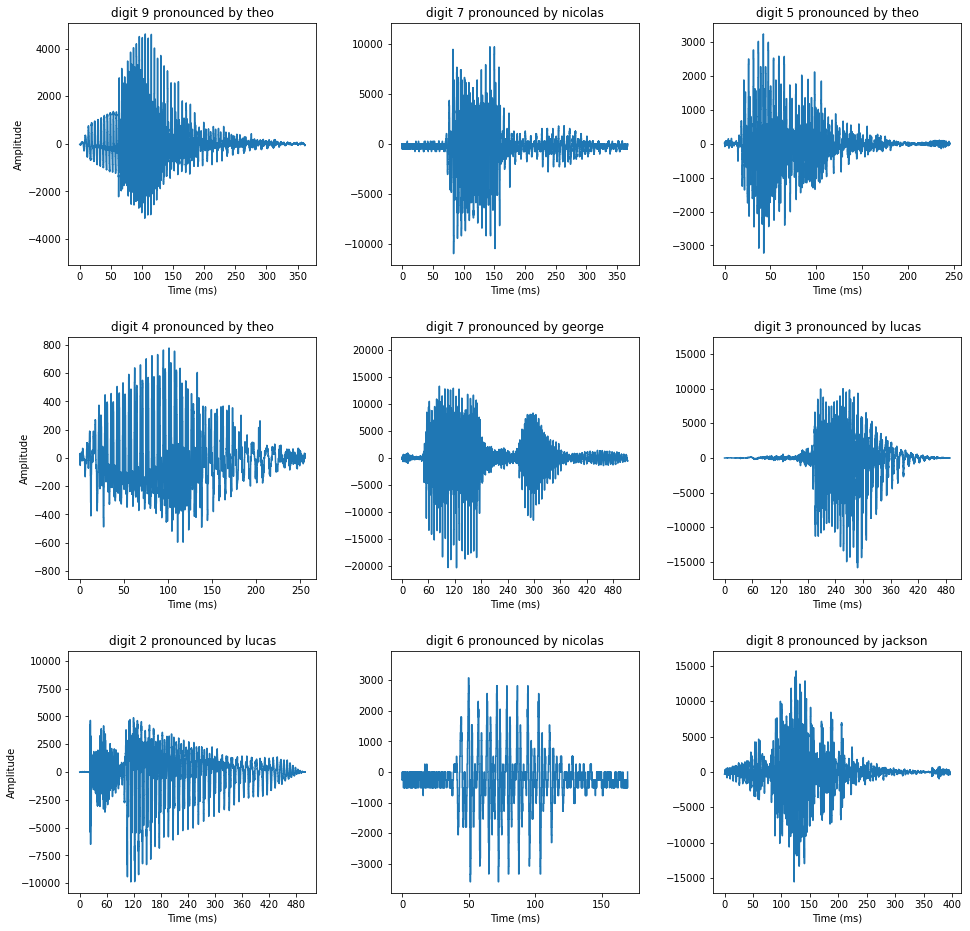

In [4]:
fig,axz=plt.subplots(3,3,figsize=(16,16),gridspec_kw=dict(hspace=0.3,wspace=0.3))
np.random.seed(5)
I=np.random.randint(0,U.shape[0],[3,3])
for i,axs in enumerate(axz):
    for j,ax in enumerate(axs):
        row=U.loc[I[i,j]]
        librosa.display.waveshow(np.array(row["Data"],dtype=float),sr=8000,ax=ax,x_axis="ms")
        ax.set_title(f"digit {row['Label']} pronounced by {row['Person']}")
        if j==0:
            ax.yaxis.set_label_text("Amplitude")
        
fig.savefig("local/digits.png")

## 3. Preprocessing
## 3.1 Augmenting dataset with repeated stochastic crop

In [5]:
from sklearn.model_selection import train_test_split
radius=2000
S,Y=U.stochasticCrop(3,to_tensor=True,radius=radius)
#X=tf.reshape(tf.signal.dct(X),X.shape+[1])
#X_train,X_test,y_train,y_test= train_test_split(X.numpy().astype(dtype=float),y.numpy(),train_size=.75)

## 3.2 Converting input to MFCC matrix

In [6]:
f,t,Z=scipy.signal.stft(S/np.max(S,axis=-1,keepdims=True),1,nperseg=1024,noverlap=256)
#X=np.stack([Z.real,Z.imag],axis=-1)
X=librosa.feature.mfcc(y=S.numpy(),sr=8000,norm="ortho",n_fft=256,hop_length=64,n_mfcc=32)
X=X.reshape(list(X.shape)+[1])
X_train,X_test,Y_train,Y_test=train_test_split(X,Y.numpy())

## 3.3 Visualising Spectogram

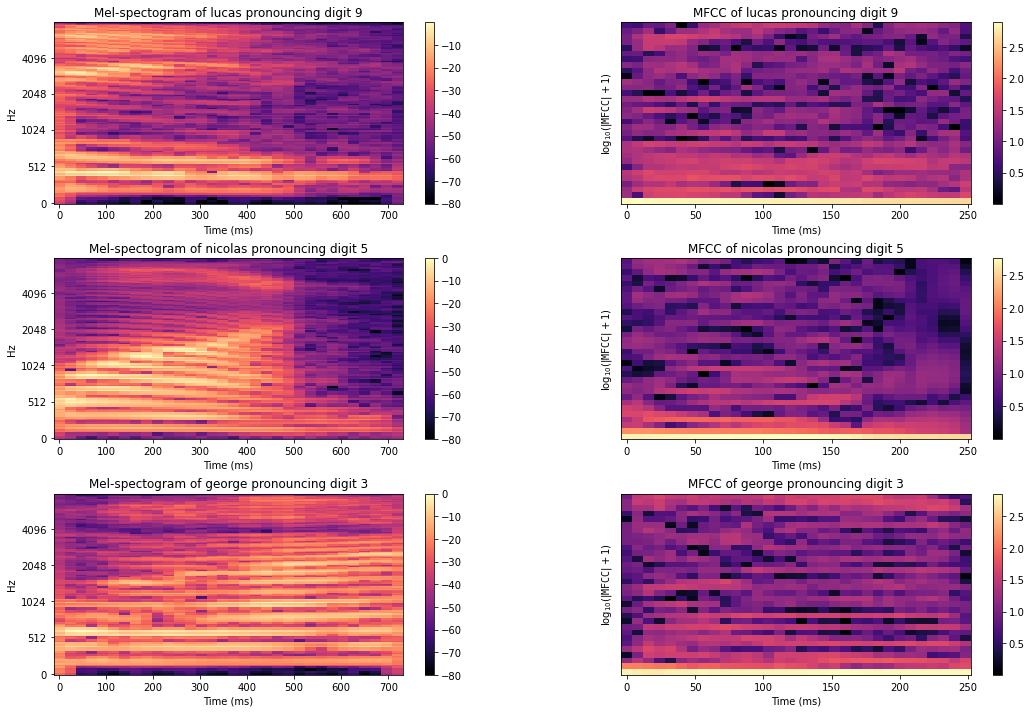

In [7]:
mel_spect=librosa.feature.melspectrogram(y=S.numpy(),sr=8000,n_fft=256,hop_length=64)
fig,axz=plt.subplots(3,2,figsize=(18,12),gridspec_kw=dict(hspace=0.3,wspace=0.3))
I=np.random.randint(0,U.shape[0],3)
for i,axs in enumerate(axz):
    row=U.loc[I[i]]
    ax1,ax2=axs
    img1=librosa.display.specshow(librosa.power_to_db(mel_spect[I[i]], ref=np.max),
                                   x_axis='ms', y_axis='mel', fmax=8000,
                                   ax=ax1)
    fig.colorbar(img1, ax=[ax1])
    ax1.set_title(f"Mel-spectogram of {row['Person']} pronouncing digit {row['Label']}")
    img2=librosa.display.specshow(np.log10(np.abs(X[I[i],...,0])+1),n_fft=256,sr=8000,x_axis="ms",hop_length=64,ax=ax2)
    ax2.yaxis.set_label_text(R"$\log_{10}(| \mathtt{MFCC} | + 1)$")
    ax2.set_title(f"MFCC of {row['Person']} pronouncing digit {row['Label']}")
    fig.colorbar(img2, ax=[ax2])


## 4. Training
## 4.1 Creating Model

In [12]:
#bnn_kwargs=dict(X_train,y_train,X_test,y_test=train_test_split(X,y))
bnn_kwargs=dict(kernel_quantizer="ste_sign",input_quantizer="ste_sign",kernel_constraint="weight_clip")
xnor_kwargs=dict(kernel_quantizer="ste_sign",input_quantizer="ste_sign",kernel_constraint="weight_clip",alpha_trainable=True)
abc_kwargs=dict(kernel_quantizers=quantizers.ShiftedSteSign,input_quantizers=quantizers.ShiftedSteSign,kernel_constraint="weight_clip",
               kernel_estimators=3)
Dense=BinaryNet.QuantDense
Conv2D=BinaryNet.QuantConv2D
model=tf.keras.Sequential([
tf.keras.layers.Normalization(),
tf.keras.layers.GaussianNoise(stddev=0.02),
#tf.keras.layers.Lambda(lambda x: x/tf.reduce_max(tf.abs(x),axis=(-3,-2),keepdims=True)),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
Conv2D(64,3,activation="tanh",padding="same",**bnn_kwargs),
tf.keras.layers.MaxPool2D(2,strides=(2,1)),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),            
Conv2D(64,3,activation="relu",padding="same",**bnn_kwargs),
tf.keras.layers.MaxPool2D(2,strides=(2,1)),
tf.keras.layers.Flatten(),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
Dense(512,activation="relu",**bnn_kwargs),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
tf.keras.layers.Dense(10),
tf.keras.layers.Activation("softmax")
])

In [30]:
Dense=BinaryNet.QuantDense
model=tf.keras.Sequential([
tf.keras.layers.Normalization(),
tf.keras.layers.GaussianNoise(stddev=0.02),
#tf.keras.layers.Lambda(lambda x: x/tf.reduce_max(tf.abs(x),axis=(-3,-2),keepdims=True)),
tf.keras.layers.Flatten(),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
Dense(1024,activation="ste_sign",**bnn_kwargs),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),            
    Dense(1024,activation="ste_sign",**bnn_kwargs),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
tf.keras.layers.Dense(10),
tf.keras.layers.Activation("softmax")
])

## 4.2 Fitting Model

In [31]:
monitor=EmissionsTracker(project_name="ABCNetMNIST")
monitor.start()
model.compile(
tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
loss="categorical_crossentropy",
metrics=["accuracy"],
)


trained_model = model.fit(
    X_train, 
    tf.one_hot(Y_train,10),
    batch_size=128, 
    epochs=90,
    validation_data=(X_test,tf.one_hot(Y_test,10)),
    shuffle=True
)
monitor.stop()

[codecarbon INFO @ 11:52:09] [setup] RAM Tracking...
[codecarbon INFO @ 11:52:09] [setup] GPU Tracking...
[codecarbon INFO @ 11:52:09] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:52:09] [setup] CPU Tracking...
[codecarbon ERROR @ 11:52:09] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 11:52:09] Tracking Intel CPU via RAPL interface
[codecarbon ERROR @ 11:52:09] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 11:52:09] >>> Tracker's metadata:
[codecarbon INFO @ 11:52:09]   Platform system: Linux-5.18.19-200.fc36.x86_64-x86_64-with-glibc

Epoch 1/90


/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


53/53 [==============================] - 1s 9ms/step - loss: 1.7959 - accuracy: 0.4336 - val_loss: 2.8976 - val_accuracy: 0.2244
Epoch 2/90
53/53 [==============================] - 0s 7ms/step - loss: 1.3873 - accuracy: 0.5335 - val_loss: 2.8804 - val_accuracy: 0.2751
Epoch 3/90
53/53 [==============================] - 0s 7ms/step - loss: 1.3815 - accuracy: 0.5437 - val_loss: 3.0386 - val_accuracy: 0.2507
Epoch 4/90
53/53 [==============================] - 0s 7ms/step - loss: 1.2813 - accuracy: 0.5767 - val_loss: 3.3197 - val_accuracy: 0.2542
Epoch 5/90
53/53 [==============================] - 0s 8ms/step - loss: 1.1180 - accuracy: 0.6124 - val_loss: 2.5150 - val_accuracy: 0.4164
Epoch 6/90
53/53 [==============================] - 0s 8ms/step - loss: 1.0778 - accuracy: 0.6369 - val_loss: 2.9582 - val_accuracy: 0.3396
Epoch 7/90
53/53 [==============================] - 0s 8ms/step - loss: 1.1567 - accuracy: 0.6287 - val_loss: 2.8961 - val_accuracy: 0.3000
Epoch 8/90
53/53 [=============

[codecarbon INFO @ 11:52:25] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.706069946289062 W
[codecarbon INFO @ 11:52:25] Energy consumed for all GPUs : 0.000171 kWh. All GPUs Power : 41.054 W
[codecarbon INFO @ 11:52:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 11:52:25] 0.000220 kWh of electricity used since the begining.


53/53 [==============================] - 0s 8ms/step - loss: 0.7846 - accuracy: 0.7596 - val_loss: 1.1465 - val_accuracy: 0.6924
Epoch 38/90
53/53 [==============================] - 0s 7ms/step - loss: 0.8179 - accuracy: 0.7585 - val_loss: 1.0062 - val_accuracy: 0.7133
Epoch 39/90
53/53 [==============================] - 0s 8ms/step - loss: 0.6861 - accuracy: 0.7787 - val_loss: 1.1519 - val_accuracy: 0.6796
Epoch 40/90
53/53 [==============================] - 0s 7ms/step - loss: 0.7429 - accuracy: 0.7730 - val_loss: 0.9246 - val_accuracy: 0.7338
Epoch 41/90
53/53 [==============================] - 0s 7ms/step - loss: 0.7311 - accuracy: 0.7707 - val_loss: 1.1070 - val_accuracy: 0.6742
Epoch 42/90
53/53 [==============================] - 0s 8ms/step - loss: 0.7452 - accuracy: 0.7742 - val_loss: 1.3228 - val_accuracy: 0.6551
Epoch 43/90
53/53 [==============================] - 0s 8ms/step - loss: 0.7360 - accuracy: 0.7766 - val_loss: 1.0609 - val_accuracy: 0.7093
Epoch 44/90
53/53 [======

[codecarbon INFO @ 11:52:40] Energy consumed for RAM : 0.000098 kWh. RAM Power : 11.706069946289062 W


10/53 [====>.........................] - ETA: 0s - loss: 0.6491 - accuracy: 0.8180

[codecarbon INFO @ 11:52:40] Energy consumed for all GPUs : 0.000313 kWh. All GPUs Power : 33.982 W
[codecarbon INFO @ 11:52:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 11:52:40] 0.000410 kWh of electricity used since the begining.


53/53 [==============================] - 0s 8ms/step - loss: 0.6630 - accuracy: 0.8090 - val_loss: 1.0774 - val_accuracy: 0.7289
Epoch 77/90
53/53 [==============================] - 0s 7ms/step - loss: 0.6263 - accuracy: 0.8157 - val_loss: 0.9553 - val_accuracy: 0.7676
Epoch 78/90
53/53 [==============================] - 0s 7ms/step - loss: 0.6491 - accuracy: 0.8184 - val_loss: 1.0655 - val_accuracy: 0.7329
Epoch 79/90
53/53 [==============================] - 0s 7ms/step - loss: 0.6541 - accuracy: 0.8154 - val_loss: 1.0436 - val_accuracy: 0.7413
Epoch 80/90
53/53 [==============================] - 0s 8ms/step - loss: 0.6378 - accuracy: 0.8185 - val_loss: 1.0468 - val_accuracy: 0.7751
Epoch 81/90
53/53 [==============================] - 0s 7ms/step - loss: 0.6752 - accuracy: 0.8121 - val_loss: 1.0200 - val_accuracy: 0.7493
Epoch 82/90
53/53 [==============================] - 0s 7ms/step - loss: 0.5936 - accuracy: 0.8321 - val_loss: 0.8901 - val_accuracy: 0.7827
Epoch 83/90
53/53 [======

[codecarbon INFO @ 11:52:45] Energy consumed for RAM : 0.000116 kWh. RAM Power : 11.706069946289062 W
[codecarbon INFO @ 11:52:45] Energy consumed for all GPUs : 0.000370 kWh. All GPUs Power : 37.507 W
[codecarbon INFO @ 11:52:45] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon INFO @ 11:52:45] 0.000486 kWh of electricity used since the begining.


0.0002989186559750748

In [23]:
model.save("trained/AudioMNIST/ABCNetMLP")

INFO:tensorflow:Assets written to: trained/AudioMNIST/ABCNetMLP/assets


INFO:tensorflow:Assets written to: trained/AudioMNIST/ABCNetMLP/assets


In [16]:
from larq_compute_engine import convert_keras_model
tflite_model = convert_keras_model(model)
with open("deployed/BinaryNet", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfmq5px2k/assets


INFO:tensorflow:Assets written to: /tmp/tmpfmq5px2k/assets
2022-08-29 03:28:25.522272: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpfmq5px2k
2022-08-29 03:28:25.525993: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-08-29 03:28:25.526036: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpfmq5px2k
2022-08-29 03:28:25.526104: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-29 03:28:25.533294: I external/org_tensorflow/tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is 

In [24]:
import larq_compute_engine
import time
lite_model=larq_compute_engine.testing.Interpreter(tflite_model,num_threads=8)
t1=time.time_ns()
lite_model.predict(X_train)
t2=time.time_ns()
print(f"Time for lite: {(t2-t1)/1e6}")

Time for lite: 9119.926911


In [20]:
with tf.device('/cpu:0'):
    t1=time.time_ns()
    model.predict(X_train)
    t2=time.time_ns()
    print(f"Time for normal: {(t2-t1)/1e6}")

211/211 [==============================] - 5s 21ms/step
Time for normal: 4648.374019


In [15]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 2000, 1)]    0           []                               
                                                                                                  
 gaussian_noise_13 (GaussianNoi  (None, 2000, 1)     0           ['input_14[0][0]']               
 se)                                                                                              
                                                                                                  
 tf.math.reduce_max (TFOpLambda  (None, 1, 1)        0           ['input_14[0][0]']               
 )                                                                                                
                                                                                            

In [25]:
full_model=tf.keras.Sequential([
tf.keras.layers.Normalization(),
tf.keras.layers.GaussianNoise(stddev=0.02),
#tf.keras.layers.Lambda(lambda x: x/tf.reduce_max(tf.abs(x),axis=(-3,-2),keepdims=True)),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
tf.keras.layers.Conv2D(64,3,activation="tanh",padding="same"),
tf.keras.layers.MaxPool2D(2,strides=(2,1)),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),            
tf.keras.layers.Conv2D(64,3,activation="relu",padding="same"),
tf.keras.layers.MaxPool2D(2,strides=(2,1)),
tf.keras.layers.Flatten(),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
tf.keras.layers.Dense(512,activation="relu"),
tf.keras.layers.BatchNormalization(momentum=0.999,scale=False),
tf.keras.layers.Dense(10),
tf.keras.layers.Activation("softmax")
])

In [26]:
full_model.compile(
tf.keras.optimizers.Adam(lr=0.01, decay=0.0001),
loss="categorical_crossentropy",
metrics=["accuracy"],
)


trained_full_model = full_model.fit(
    X_train, 
    tf.one_hot(Y_train,10),
    batch_size=128, 
    epochs=90,
    validation_data=(X_test,tf.one_hot(Y_test,10)),
    shuffle=True
)

Epoch 1/90


/home/ramizouari/anaconda3/envs/tensorflow_2_9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


53/53 [==============================] - 2s 20ms/step - loss: 0.8276 - accuracy: 0.7846 - val_loss: 61.6733 - val_accuracy: 0.2444
Epoch 2/90
53/53 [==============================] - 1s 18ms/step - loss: 0.1704 - accuracy: 0.9507 - val_loss: 28.4885 - val_accuracy: 0.2431
Epoch 3/90
53/53 [==============================] - 1s 17ms/step - loss: 0.1004 - accuracy: 0.9696 - val_loss: 11.2286 - val_accuracy: 0.4138
Epoch 4/90
53/53 [==============================] - 1s 17ms/step - loss: 0.0623 - accuracy: 0.9836 - val_loss: 9.2625 - val_accuracy: 0.3671
Epoch 5/90
53/53 [==============================] - 1s 18ms/step - loss: 0.0515 - accuracy: 0.9862 - val_loss: 7.9735 - val_accuracy: 0.3502
Epoch 6/90
53/53 [==============================] - 1s 18ms/step - loss: 0.0648 - accuracy: 0.9841 - val_loss: 1.6438 - val_accuracy: 0.7009
Epoch 7/90
53/53 [==============================] - 1s 17ms/step - loss: 0.0705 - accuracy: 0.9796 - val_loss: 0.9956 - val_accuracy: 0.7716
Epoch 8/90
53/53 [===

In [28]:
import larq_compute_engine
import time
lite_model=larq_compute_engine.testing.Interpreter(convert_keras_model(full_model),num_threads=8)
t1=time.time_ns()
lite_model.predict(X_train)
t2=time.time_ns()
print(f"Time for lite: {(t2-t1)/1e6}")

INFO:tensorflow:Assets written to: /tmp/tmpd5oyxlg2/assets


INFO:tensorflow:Assets written to: /tmp/tmpd5oyxlg2/assets
2022-08-29 03:35:58.001604: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpd5oyxlg2
2022-08-29 03:35:58.003855: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-08-29 03:35:58.003885: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpd5oyxlg2
2022-08-29 03:35:58.010077: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-08-29 03:35:58.105879: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpd5oyxlg2
2022-08-29 03:35:58.125532: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 123930 microseconds.
2022-08-29 03:35:58.361370: I external/or

Time for lite: 7244.521164


0

In [39]:
tf.transpose(model.layers[8].kernel).shape

TensorShape([10, 1024])

In [37]:
U.sample(10)

,Person,Rate,Size,Data,Label
453,nicolas,8000,2980,0 -256 1 -512 2 -256 3 -51...,1
471,nicolas,8000,2584,0 0 1 -512 2 -256 3 -51...,1
838,theo,8000,1854,0 4 1 10 2 4 3 3 4 ...,2
2532,lucas,8000,3837,0 -9 1 -3 2 0 3 3 4 ...,8
2224,lucas,8000,5443,0 4 1 15 2 5 3 7 4 ...,7
2084,yweweler,8000,1450,0 0 1 7 2 2 3 5 4 ...,6
2805,lucas,8000,6995,0 -6 1 -9 2 8 3 24 4 ...,9
530,theo,8000,2244,0 -25 1 -17 2 -14 3 -23 4 ...,1
1093,nicolas,8000,2397,0 -256 1 0 2 0 3 -25...,3
2430,george,8000,3306,0 -1034 1 -744 2 -1838 3 ...,8


,Person,Rate,Size,Data,Label
0,george,8000,2384,0 -1489 1 -962 2 -606 3 ...,0
1,george,8000,4727,0 36 1 18 2 63 3 75 4 ...,0
2,george,8000,5958,0 -175 1 -509 2 293 3 24...,0
3,george,8000,3661,0 103 1 138 2 196 3 17...,0
4,george,8000,4050,0 67 1 91 2 104 3 14...,0
...,...,...,...,...,...
2995,yweweler,8000,2877,0 -3 1 -13 2 0 3 -10 4 ...,9
2996,yweweler,8000,2778,0 -7 1 10 2 11 3 12 4 ...,9
2997,yweweler,8000,2815,0 8 1 3 2 8 3 2 4 ...,9
2998,yweweler,8000,3164,0 12 1 4 2 15 3 10 4 ...,9


In [21]:
#Every single line comment in python starts with #
import numpy as np
#sklearn.datasets contains some predefined datasets
import sklearn.datasets as ds
#pandas is used for data manipulation
import pandas as pd
#matplotlib.pyplot is used for visualisation
import matplotlib.pyplot as plt
#seaborn is a user friendly library for visualisation built on top of matplotlib
import seaborn as sns
#we will use a Classification Model called LogisticRegression
from sklearn.linear_model import LogisticRegression
#we will split the data using train_test_split
from sklearn.model_selection import train_test_split
#OPTIONAL: This is for evaluating a classification model
from sklearn.metrics import confusion_matrix
print("Libraries were successfully imported")

Libraries were successfully imported


In [24]:
#Load the IRIS dataset
iris_dataset=ds.load_iris()
#X is a DataFrame (Matrix/2D array) containing the features of the iris data 
X=pd.DataFrame(iris_dataset["data"])
#y contains the numeric value/label of each iris flower, respecting the order 
#y is a vector (Series/1D array)
y=pd.Series(iris_dataset["target"],name ="Target")
#y_name contains the true name of each iris flower
y_name=pd.Series(iris_dataset["target_names"],name="Species")
#Feature Names and removing ' (cm)'
feature_names = [feature_name[:-5] for feature_name in iris_dataset["feature_names"]]
X.columns=feature_names


In [26]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=.8)

In [31]:
#Creating Model
model = LogisticRegression(C=1,max_iter=1000)
#Fitting Model
#A semi-colon ';' is used to suppress output, Try to remove it and see the difference
model.fit(X_train,y_train);

In [36]:
model.score(X_train,y_train)

0.975

In [ ]:
U